In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import numpy as np
import torch
from torch import Tensor
import torchvision
from torch import nn
from d2l import torch as d2l
import myKit
from PIL import Image, ImageOps
import torch.nn.functional as F
import print_animator

In [2]:
def accuracy(y_hat, y):
    """得出精确数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))
def loss_map(class_loss, class_num):
    """"输入参数：各个年龄的损失class_loss，各个年龄的数量class_num，画出每个年龄的误差图"""
    data = torch.zeros((230, 1))
    for i in range(class_loss.shape[0]):
        if class_num[i]:
            data[i] =  class_loss[i] / class_num[i]
    legend = ['MAE']
    animator = print_animator.Animator(xlabel='month', xlim=[1, 230], legend=legend)
    for i in range(data.shape[0]):
        animator.add(i, data[i])
    animator.save('loss_map.png')
def evaluate_fn(data_iter, net, devices):
    net.eval()
    pred_list = torch.zeros((1, 230))
    grand_age = torch.zeros((1,))
    mae_loss = torch.tensor([0], dtype=torch.float32)
    val_total_size = torch.tensor([0], dtype=torch.float32)
    class_loss = torch.zeros((230, 1))
    class_num = torch.zeros((230, 1))
    with torch.no_grad():
        for batch_idx, data in enumerate(data_iter):
            val_total_size += len(data[1])
            image, gender = data[0]
            image, gender = image.type(torch.FloatTensor).to(devices), gender.type(torch.FloatTensor).to(devices)
            label = data[1].type(torch.FloatTensor).to(devices)
            AM1, AM2, AM3, AM4, feature_map, texture, gender_encode, y_pred = net(image, gender)
            y_pred = y_pred.cpu()
            label = label.cpu()
            pred_list = torch.cat([pred_list, y_pred], dim=0)
            grand_age = torch.cat([grand_age, label], dim=0)
            y_pred = y_pred.argmax(axis=1).type(torch.FloatTensor)
            batch_loss = F.l1_loss(y_pred, label, reduction='none')
            for i in range(label.shape[0]):
                class_loss[int(label[i])] += batch_loss[i]
                class_num[int(label[i])] += 1
            batch_loss = batch_loss.sum().item()
            mae_loss += batch_loss
    loss_map(class_loss, class_num)
    accuracy_num = accuracy(pred_list[1:, :], grand_age[1:])
    print(f'val loss is {mae_loss / val_total_size}, accuracy : {accuracy_num / val_total_size}')
    return AM1, AM2, AM3, AM4

In [3]:
net = torch.load('./model_no_AM.pth')
device = myKit.try_gpu()
net = net.to(device = device)
# net

In [4]:
from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Lambda
from torch.utils.data import Dataset

In [5]:
# 标准化每个通道
def sample_normalize(image, **kwargs):
    image = image/255
    channel = image.shape[2]
    mean, std = image.reshape((-1, channel)).mean(axis = 0), image.reshape((-1, channel)).std(axis = 0)
    return (image - mean)/(std + 1e-3)


In [6]:
def read_image(data_dir, fname, image_size=512):
    img = Image.open(os.path.join(data_dir, fname))
    # 开始修改尺寸
    w, h = img.size
    long = max(w, h)
    # 按比例缩放成512
    w, h = int(w/long*image_size), int(h/long*image_size)
    # 压缩并插值
    img = img.resize((w, h), Image.ANTIALIAS)
    # 然后是给短边扩充，使用ImageOps.expand
    delta_w, delta_h = image_size - w, image_size - h
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    # 转化成np.array再返回
    return np.array(ImageOps.expand(img, padding).convert("RGB"))

In [7]:
# 验证集的数据处理
transform_valid = Compose([
    Lambda(image=sample_normalize),
    ToTensorV2()
])
class BAAValDataset(Dataset):

    def __init__(self, df, file_path) -> None:
        def preprocess_df(df):
            #change the type of gender, change bool variable to float32
            df['male'] = df['male'].astype('float32')
            df['bonage'] = df['boneage'].astype('float32')
            return df
        self.df = preprocess_df(df)
        self.file_path = file_path

    def __getitem__(self, index):
        row = self.df.iloc[index]
        num = int(row['id'])
        return (transform_valid(image=read_image(self.file_path, f"{num}.png"))['image'], Tensor([row['male']])), row['boneage']

    def __len__(self):
        return len(self.df)

val_df = pd.read_csv(f'../data/archive/valid-dataset.csv')
file_path = '../data/archive/valid-dataset'
valid_dataset = BAAValDataset(val_df, file_path)
val_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=10,
    shuffle=True,
    drop_last=True)

In [8]:
unloader = torchvision.transforms.ToPILImage()

val loss is tensor([2.7200]), accuracy : tensor([0.8300])


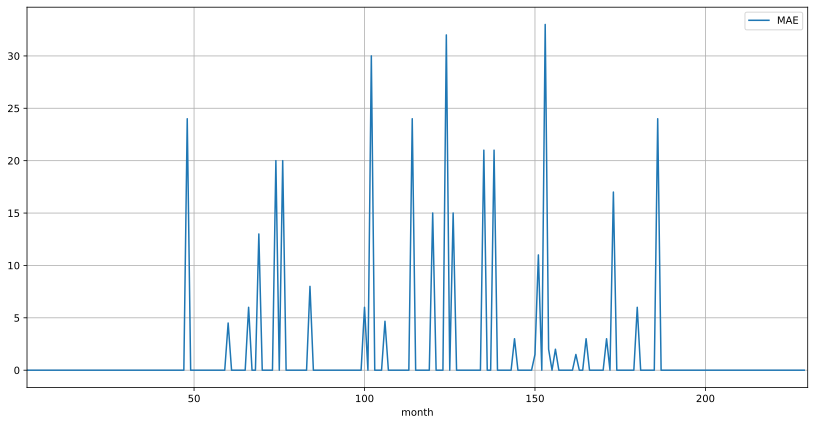

In [9]:
AM1, AM2, AM3, AM4 = evaluate_fn(val_loader, net, device)

In [10]:
import matplotlib.pyplot as plt

In [11]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img, cmap='gray')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    fig.savefig('./attentionMap.png')
    return axes

In [12]:
images = []

# plt_pic = []
# for i in range(images.shape[0]):
#     img = images[i, :, :, :].squeeze()
#     img = img.cpu().clone()
#     img = unloader(img)
#     plt_pic.append(img)
# show_images(images, num_rows=1, num_cols=10, scale=2)

In [13]:
def apply(img, num_cols, num_rows=5):
    show_images(img, num_rows, num_cols, scale=2)

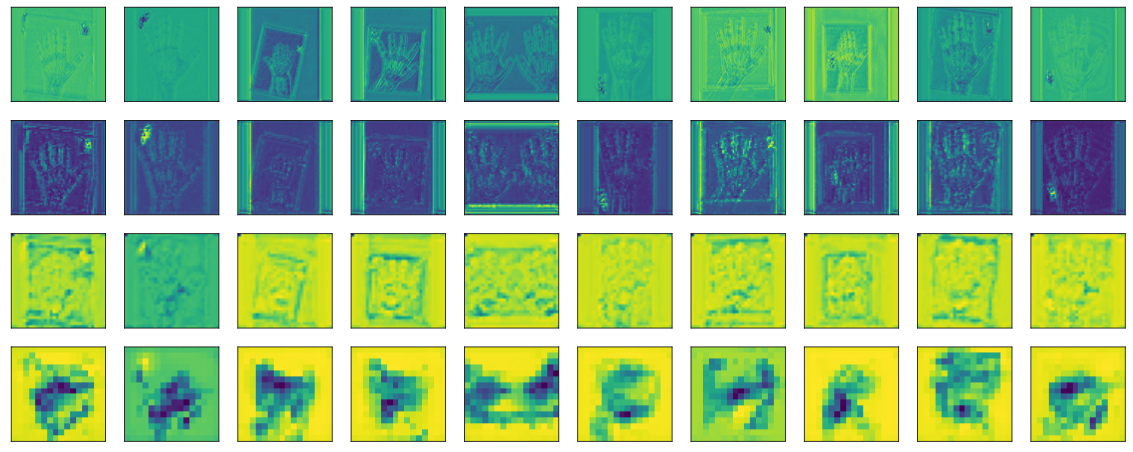

In [14]:
def print_AM(AM1, AM2, AM3, AM4):
    plt_pic = []
    # for root, dirs, files in os.walk(file_path):
    #     files.sort(key=lambda x: int(x[:-4]))
    #     for file in files:
    #         if ".png" in file:
    #             img = Image.open(os.path.join(root, file))
    #             plt_pic.append(img)
    for i in range(AM1.shape[0]):
        img = AM1[i, :, :, :].squeeze()
        img = img.cpu().clone()
        # img = unloader(img)
        plt_pic.append(img)
    for i in range(AM2.shape[0]):
        img = AM2[i, :, :, :].squeeze()
        img = img.cpu().clone()
        # img = unloader(img)
        plt_pic.append(img)
    for i in range(AM3.shape[0]):
        img = AM3[i, :, :, :].squeeze()
        img = img.cpu().clone()
        # img = unloader(img)
        plt_pic.append(img)
    for i in range(AM4.shape[0]):
        img = AM4[i, :, :, :].squeeze()
        img = img.cpu().clone()
        # img = unloader(img)
        plt_pic.append(img)
    apply(img=plt_pic, num_cols=AM1.shape[0], num_rows=4)
# print_AM(file_path, AM1, AM2, AM3, AM4)
print_AM(AM1, AM2, AM3, AM4)

In [15]:
AM4.shape

torch.Size([10, 1, 16, 16])